In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import traceback
import datetime
from datetime import timedelta
from datetime import date
#from datetime import datetime

In [2]:
# 데이터 분석 기본 라이브러리 관련
import os
import sys
import platform
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

# EDA 관련
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#import missingno as msno

# 데이터 전처리 관련
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
from matplotlib.dates import YearLocator, MonthLocator
import matplotlib.cm as cm

In [4]:
warnings.filterwarnings(action='ignore')

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
plt.style.use('ggplot')

current_os = platform.platform().split("-")[0]
if current_os == 'Windows':
    print(f'현재 사용되는 운영체제: {current_os}')
    plt.rc('font', family='Malgun Gothic') # For Windows
    plt.rc("axes",unicode_minus=False)
elif current_os == 'Darwin': # macOS
    print(f"본 내용은 Windows 환경에서 분석됐습니다. 다른 OS로 하시게 될 경우 에러가 날 수 있습니다.")
    plt.rc('font', family='AppleGothic') # For Windows

현재 사용되는 운영체제: Windows


## 데이터 불러오고 TRAIN/VAL/TEST SPLIT

In [5]:
SK하이닉스_df =pd.read_csv('C:/Users/sas/Desktop/빅통분/data/sk하이닉스.csv',encoding='cp949')

In [6]:
SK하이닉스_df ['날짜']=pd.to_datetime(SK하이닉스_df.날짜,format='%Y-%m-%d')
SK하이닉스_df.index=SK하이닉스_df['날짜']

In [7]:
SK하이닉스_df=SK하이닉스_df[(SK하이닉스_df.index>='2013.01.01')&(SK하이닉스_df.index<='2019.12.31')]

In [8]:
data=SK하이닉스_df[['종가']]
data.head()

,종가
날짜,
2013-01-02,26600.0
2013-01-03,26650.0
2013-01-04,26350.0
2013-01-07,25900.0
2013-01-08,26250.0


## MOVING AVERAGE

In [11]:
trval=data[(data.index>='2013-01-01') & (data.index<'2019-09-01')] 
test=data[(data.index>='2019-09-01') & (data.index<='2019-12-31')]
train, val=train_test_split(trval,test_size=0.2,shuffle=False)

In [12]:
preds=[]
for i in range(0,val.shape[0]):
    a=train['종가'][len(train)-329+i:].sum()+sum(preds)
    b=a/329
    preds.append(b)

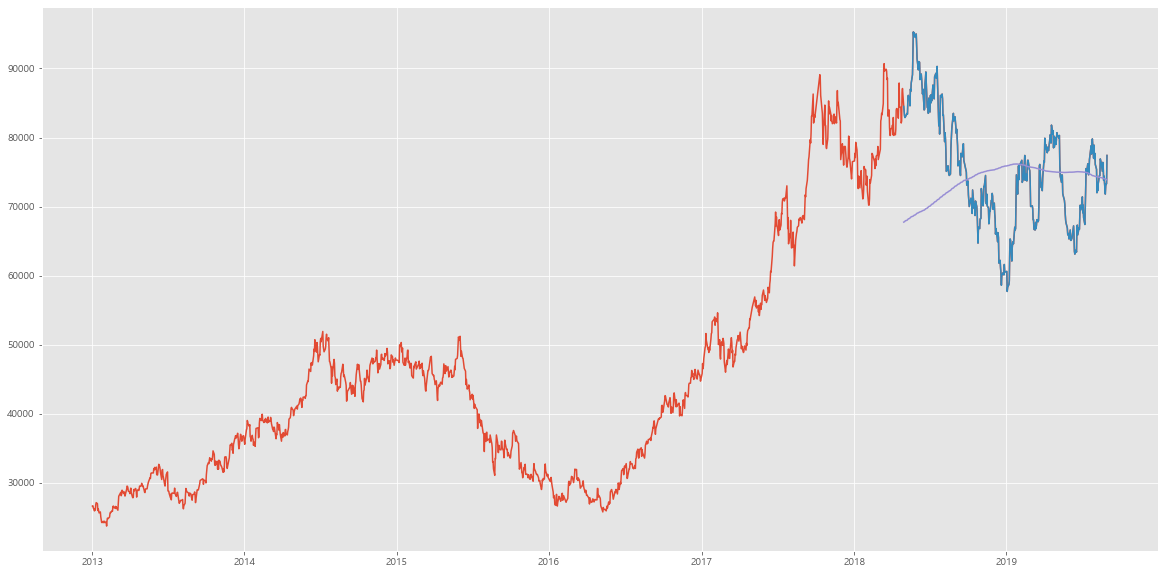

In [11]:
val['MA']=preds
plt.figure(figsize=(20,10))
plt.plot(trval['종가'])
plt.plot(val[['종가','MA']])

In [12]:
rmse_ma =np.sqrt(np.mean(np.power((np.array(val['종가'])-preds),2)))
rmse_ma

10046.741363883764

In [13]:
mape_ma = np.divide(np.sum(np.divide(np.absolute(np.array(val['종가'])-preds),val['종가']),0),val['종가'].shape[0])
mape_ma

0.1038315471361899

## LINEAR REGRESSION

In [14]:
data2=SK하이닉스_df[['날짜','종가']]
data2.reset_index(drop=True,inplace=True)
data2

,날짜,종가
0,2013-01-02,26600.0
1,2013-01-03,26650.0
2,2013-01-04,26350.0
3,2013-01-07,25900.0
4,2013-01-08,26250.0
...,...,...
1714,2019-12-23,94600.0
1715,2019-12-24,93800.0
1716,2019-12-26,94800.0
1717,2019-12-27,96000.0


In [15]:
data2['time']=data2.sort_index(ascending=True).index+1

In [16]:
trval2=data2[(data2.날짜>='2013-01-01') & (data2.날짜<'2019-09-01')]
test2=data2[(data2.날짜>='2019-09-01') & (data2.날짜<='2019-12-31')]
train2, val2=train_test_split(trval2,test_size=0.2,shuffle=False)

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [18]:
close_tr=train2['종가']
time_tr=train2['time']
time_tr=sm.add_constant(time_tr)
mod=sm.OLS(close_tr,time_tr)
res=mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     종가   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     1312.
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          1.52e-199
Time:                        17:15:08   Log-Likelihood:                -14114.
No. Observations:                1310   AIC:                         2.823e+04
Df Residuals:                    1308   BIC:                         2.824e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.451e+04    639.587     38.315      0.0

In [19]:
close_val=val2['종가']
time_val=val2['time']
time_val=sm.add_constant(time_val)
val_result=res.predict(time_val)

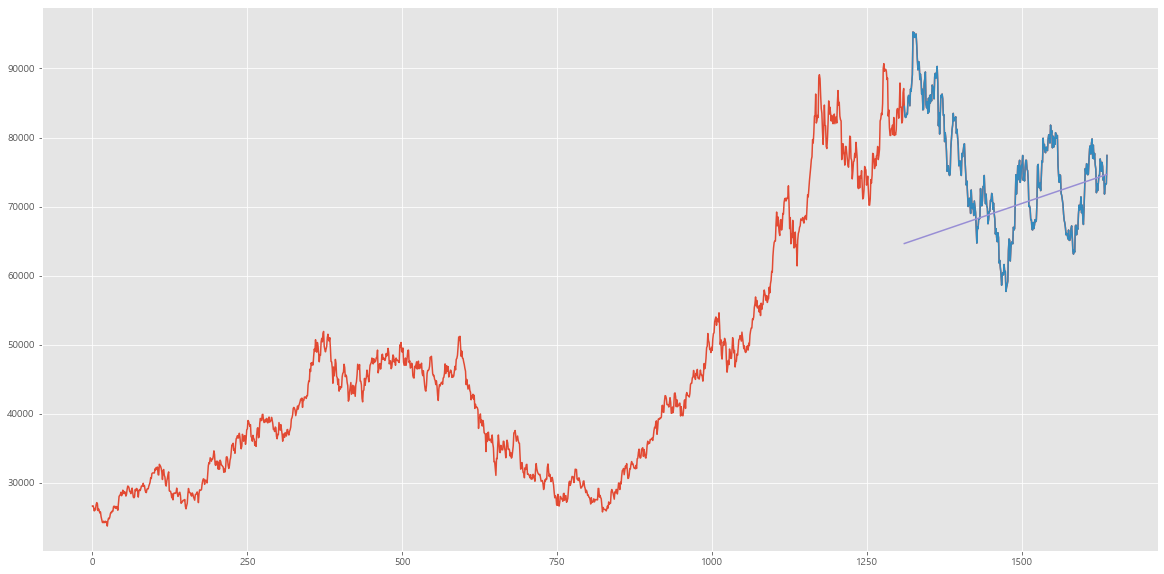

In [20]:
val2['LM']=val_result
plt.figure(figsize=(20,10))
plt.plot(trval2['종가'])
plt.plot(val2[['종가','LM']])

In [21]:
rmse_lm_1 =np.sqrt(np.mean(np.power((np.array(val['종가'])-val_result),2)))
rmse_lm_1

11253.943648067174

In [22]:
mape_lm_1 = np.divide(np.sum(np.divide(np.absolute(np.array(val2['종가'])-val_result),val2['종가']),0),val2['종가'].shape[0])
mape_lm_1

0.1061221024916873

## POLYNOMIAL REGRESSION

In [23]:
data3=SK하이닉스_df[['날짜','종가']]
data3.reset_index(drop=True,inplace=True)
data3['time']=data3.sort_index(ascending=True).index+1
data3['timebytime']=data3['time']*data3['time']

In [24]:
trval3=data3[(data3.날짜>='2013-01-01') & (data3.날짜<'2019-09-01')]
test3=data3[(data3.날짜>='2019-09-01') & (data3.날짜<='2019-12-31')]
train3, val3=train_test_split(trval3,test_size=0.2,shuffle=False)

In [25]:
data3

,날짜,종가,time,timebytime
0,2013-01-02,26600.0,1,1
1,2013-01-03,26650.0,2,4
2,2013-01-04,26350.0,3,9
3,2013-01-07,25900.0,4,16
4,2013-01-08,26250.0,5,25
...,...,...,...,...
1714,2019-12-23,94600.0,1715,2941225
1715,2019-12-24,93800.0,1716,2944656
1716,2019-12-26,94800.0,1717,2948089
1717,2019-12-27,96000.0,1718,2951524


In [26]:
trval3=data3[(data3.날짜>='2013-01-01') & (data3.날짜<'2019-09-01')]
test3=data3[(data3.날짜>='2019-09-01') & (data3.날짜<='2019-12-31')]
train3, val3=train_test_split(trval3,test_size=0.2,shuffle=False)

In [27]:
close_tr=train3['종가']
time_tr=train3[['time','timebytime']]
time_tr=sm.add_constant(time_tr)
mod=sm.OLS(close_tr,time_tr)
res=mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     종가   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     1168.
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          1.20e-291
Time:                        17:15:09   Log-Likelihood:                -13898.
No. Observations:                1310   AIC:                         2.780e+04
Df Residuals:                    1307   BIC:                         2.782e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.825e+04    814.392     46.963      0.0

In [28]:
close_val=val3['종가']
time_val=val3[['time','timebytime']]
time_val=sm.add_constant(time_val)
val_result=res.predict(time_val)

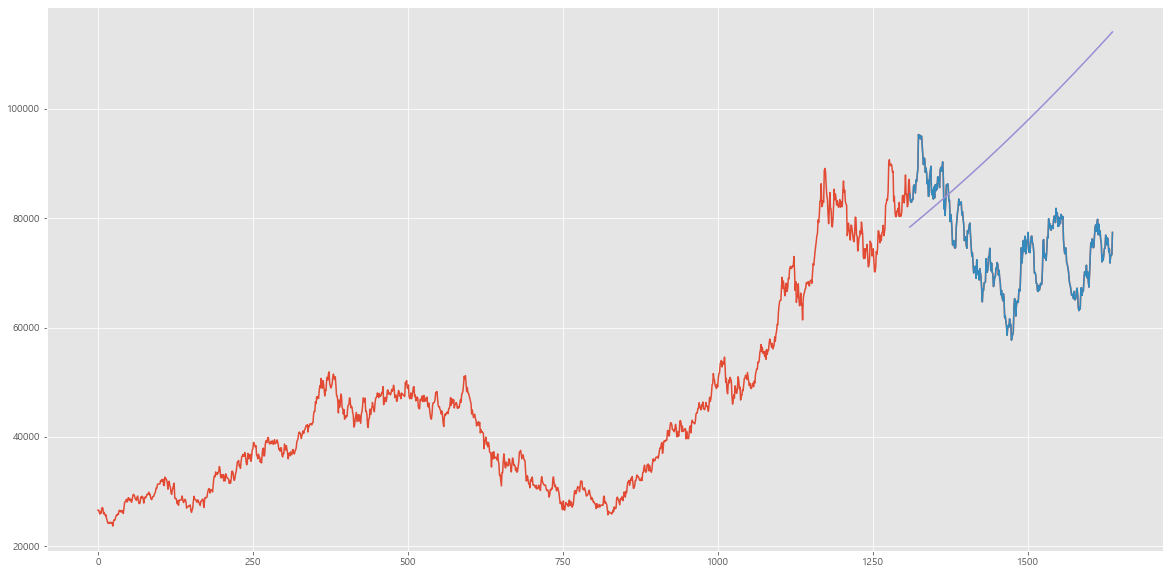

In [29]:
val3['PLM']=val_result
plt.figure(figsize=(20,10))
plt.plot(trval3['종가'])
plt.plot(val3[['종가','PLM']])

In [30]:
rmse_poly=np.sqrt(np.mean(np.power((np.array(val3['종가'])-val_result),2)))
rmse_poly

25809.99839497344

In [31]:
mape_poly = np.divide(np.sum(np.divide(np.absolute(np.array(val3['종가'])-val_result),val3['종가']),0),val3['종가'].shape[0])
mape_poly

0.3172983377157997

## LINEAR REGRESSION W/ DIFFERENT INDEPENDENT VARIABLES 

In [32]:
data4=SK하이닉스_df[['날짜','종가']]
data4.reset_index(drop=True,inplace=True)
data4['year']=data4['날짜'].dt.year
data4['month']=data4['날짜'].dt.month
data4['day']=data4['날짜'].dt.day

In [33]:
def weekday(x):
    year=x['year']
    month=x['month']
    day=x['day']
    weekday=date(year,month,day).weekday()
    return weekday

def dayOfYear(x):
    year=x['year']
    month=x['month']
    day=x['day']
    days=[31,28,31,30,31,30,31,31,30,31,30,31]
    answer=sum(days[:month-1])+day
    if(((year%4==0) & (year%100!=0))|(year%400==0)&month>2):
        answer+=1
    return answer

In [34]:
data4['weekday']=data4.apply(weekday,axis=1)
data4['dayofyear']=data4.apply(dayOfYear,axis=1)
data4['is_month_start']=data4['날짜'].dt.is_month_start*1
data4['is_month_end']=data4['날짜'].dt.is_month_end*1
data4['is_quarter_start']=data4['날짜'].dt.is_quarter_start*1
data4['is_quarter_end']=data4['날짜'].dt.is_quarter_end*1

In [35]:
data4['mon_fri']=0
for i in range(0,len(data4)):
    if((data4['weekday'][i]==0)|data4['weekday'][i]==4):
        data4['mon_fri'][i]=1
    else:
        data4['mon_fri'][i]=0

In [36]:
data4.index=data4['날짜']
data4=data4.drop(['날짜'],axis=1)

In [37]:
data4

,종가,year,month,day,weekday,dayofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,mon_fri
날짜,,,,,,,,,,,
2013-01-02,26600.0,2013,1,2,2,2,0,0,0,0,0
2013-01-03,26650.0,2013,1,3,3,3,0,0,0,0,0
2013-01-04,26350.0,2013,1,4,4,4,0,0,0,0,1
2013-01-07,25900.0,2013,1,7,0,7,0,0,0,0,0
2013-01-08,26250.0,2013,1,8,1,8,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,94600.0,2019,12,23,0,357,0,0,0,0,0
2019-12-24,93800.0,2019,12,24,1,358,0,0,0,0,0
2019-12-26,94800.0,2019,12,26,3,360,0,0,0,0,0


In [38]:
trval4=data4[(data4.index>='2013-01-01') & (data4.index<'2019-09-01')]
test4=data4[(data4.index>='2019-09-01') & (data4.index<='2019-12-31')]
train4, val4=train_test_split(trval4,test_size=0.2,shuffle=False)

tr_x=train4.drop('종가',axis=1)
tr_y=train4['종가']
val_x=val4.drop('종가',axis=1)
val_y=val4['종가']

In [39]:
from sklearn import linear_model

In [40]:
lm = linear_model.LinearRegression()
model = lm.fit(tr_x,tr_y)

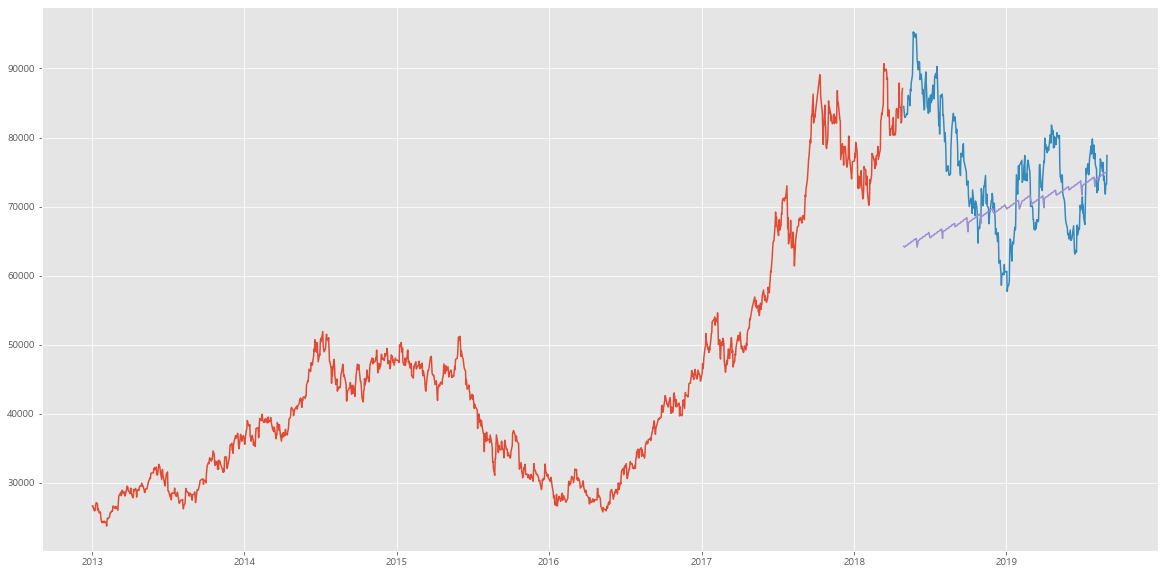

In [41]:
val4['LM2'] = lm.predict(val_x)
plt.figure(figsize=(20,10))
plt.plot(train4['종가'])
plt.plot(val4[['종가', 'LM2']])

In [42]:
preds=model.predict(val_x)
rmse_lm2=np.sqrt(np.mean(np.power((np.array(val_y)-np.array(preds)),2)))
rmse_lm2

11292.062571689095

In [43]:
mape_lm2 = np.divide(np.sum(np.divide(np.absolute(np.array(val4['종가'])-preds),val4['종가']),0),val4['종가'].shape[0])
mape_lm2

0.10597520577419008

## KNN

In [44]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [45]:
tr_x_scaled=scaler.fit_transform(tr_x)
tr_x=pd.DataFrame(tr_x_scaled)
val_x_scaled=scaler.fit_transform(val_x)
val_x=pd.DataFrame(val_x_scaled)

In [46]:
params={'n_neighbors':[3,5,10,15,20,25,30]}
knn=neighbors.KNeighborsRegressor()
model=GridSearchCV(knn, params, cv=5)
model.fit(tr_x,tr_y)
preds=model.predict(val_x)

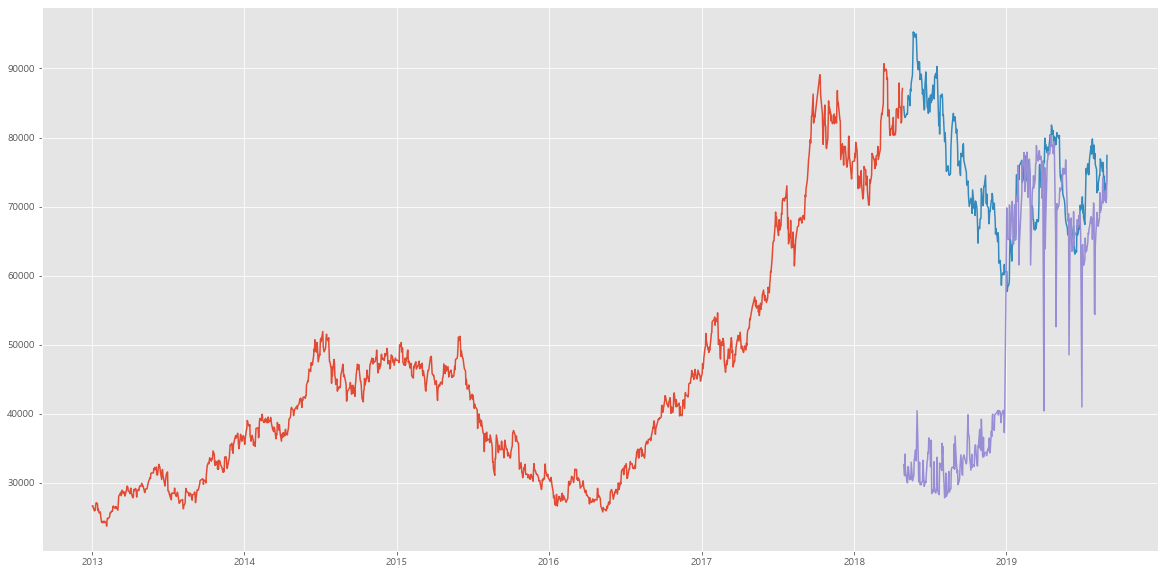

In [47]:
val4['KNN'] = preds
plt.figure(figsize=(20,10))
plt.plot(train4['종가'])
plt.plot(val4[['종가', 'KNN']])

In [48]:
rmse_knn=np.sqrt(np.mean(np.power((np.array(val_y)-np.array(preds)),2)))
rmse_knn

32800.36556347446

In [49]:
mape_knn = np.divide(np.sum(np.divide(np.absolute(np.array(val4['종가'])-preds),val4['종가']),0),val4['종가'].shape[0])
mape_knn

0.3166896844666567

## HMM ( HIDDEN MARKOV MODEL )

In [50]:
data5=SK하이닉스_df[['날짜','종가']]
trval5=data5[:-81]

In [51]:
start_date=datetime.date(2013,1,2)
end_date=datetime.date(2018,4,29)
dataset5=trval5[:1310]
dataset5.reset_index(drop=True,inplace=True)
dataset5['날짜']=dataset5['날짜'].apply(datetime.datetime.toordinal)

dataset5=list(dataset5.itertuples(index=False,name=None))
dates=np.array([q[0]for q in dataset5],dtype=int)
close=np.array([q[1] for q in dataset5])

diff=np.diff(close)
dates=dates[1:]
close=close[1:]
X=np.column_stack([diff])

In [52]:
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM

In [53]:
model=GaussianHMM(n_components=4,covariance_type='diag',n_iter=1000)
model.fit(X)

GaussianHMM(n_components=4, n_iter=1000)

In [54]:
hidden_states=model.predict(X)

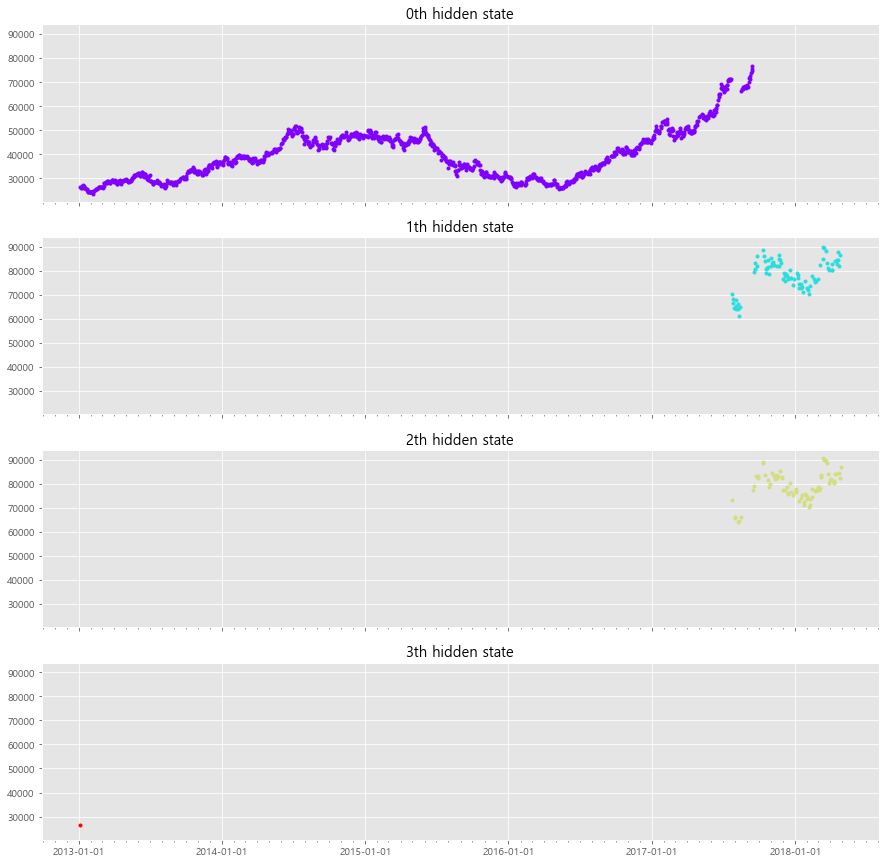

In [55]:
fig, axs = plt.subplots(model.n_components,sharex=True,sharey=True,figsize=(15,15))
colours=cm.rainbow(np.linspace(0,1,model.n_components))
for i,(ax,colour) in enumerate(zip(axs,colours)):
    mask=hidden_states==i
    ax.plot_date(dates[mask],close[mask],'.',c=colour)
    ax.set_title('{0}th hidden state'.format(i))
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    ax.grid(True)
    
plt.show()

In [56]:
expected_return=np.dot(model.transmat_,model.means_)
returns_columnwise = list(zip(*expected_return))
expected_returns=returns_columnwise[0]
params=pd.Series(expected_returns)
params.columns=['Returns']
print(params)

0    46.467015
1    52.422723
2    45.831149
3    36.326605
dtype: float64


In [57]:
lastN=328

start_date=datetime.date(2019,8,30)-datetime.timedelta(days=lastN*2)
dates=np.array([q[0] for q in dataset5],dtype=int)

In [58]:
predicted_prices=[]
predicted_dates=[]

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = dataset5[-lastN+idx][1]
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=330)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])


In [59]:
trval5=data[(data.index>='2013-01-01') & (data.index<'2019-09-01')]
train5, val5=train_test_split(trval5,test_size=0.2,shuffle=False)
val5['hmm']=predicted_prices

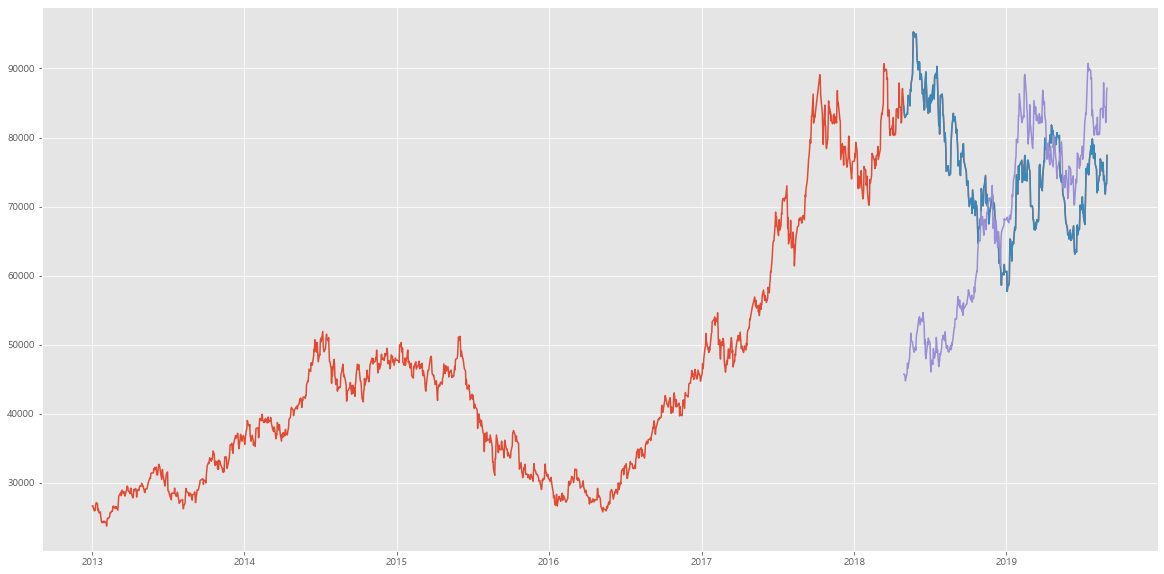

In [60]:
plt.figure(figsize=(20,10))
plt.plot(trval5['종가'])
plt.plot(val5[['종가','hmm']])

In [61]:
rmse_hmm=np.sqrt(np.mean(np.power((np.array(val5['종가'])-np.array(predicted_prices)),2)))
rmse_hmm

20067.838551196066

In [62]:
mape_hmm = np.divide(np.sum(np.divide(np.absolute(np.array(val5['종가'])-predicted_prices),val5['종가']),0),val5['종가'].shape[0])
mape_hmm

0.19075511609379325

## PROPHET

In [9]:
from fbprophet import Prophet

In [10]:
data6=SK하이닉스_df[['날짜','종가']]
data6.reset_index(drop=True,inplace=True)

In [12]:
trval6=data6[(data6.날짜>='2013-01-01') & (data6.날짜<'2019-09-01')]
test6=data6[(data6.날짜>='2019-09-01') & (data6.날짜<='2019-12-31')]
train6, val6=train_test_split(trval6,test_size=0.2,shuffle=False)

In [13]:
df = train6.reset_index().rename(columns={'날짜':'ds', '종가':'y'})
df['y'] = np.log(df['y'])
model = Prophet()
model.fit(df);
future = model.make_future_dataframe(periods=328) #forecasting val
forecast = model.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


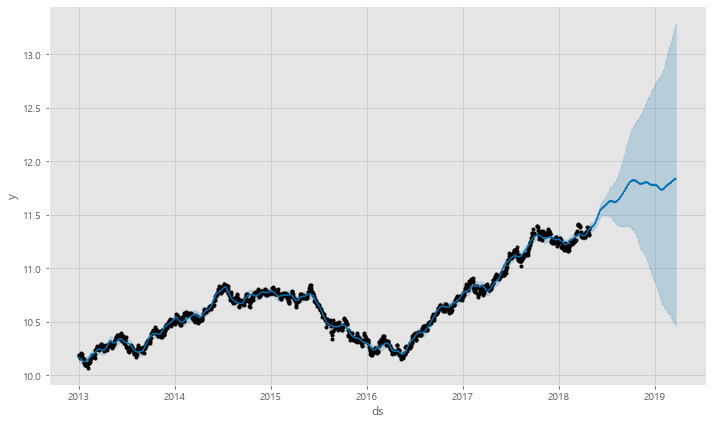

In [14]:
figure=model.plot(forecast)

In [15]:
yhat = forecast.set_index('ds').join(train6)

import math
a = np.array(yhat["yhat"].values.tolist())
yhatt = np.exp(a)
yhatt

array([ 25979.3233374 ,  25975.99938281,  25921.40307239, ...,
       138386.3272769 , 138569.30199979, 138589.71414584])

In [16]:
val_yhat = yhatt[-328:]
val_y = val6["종가"] #실제 y

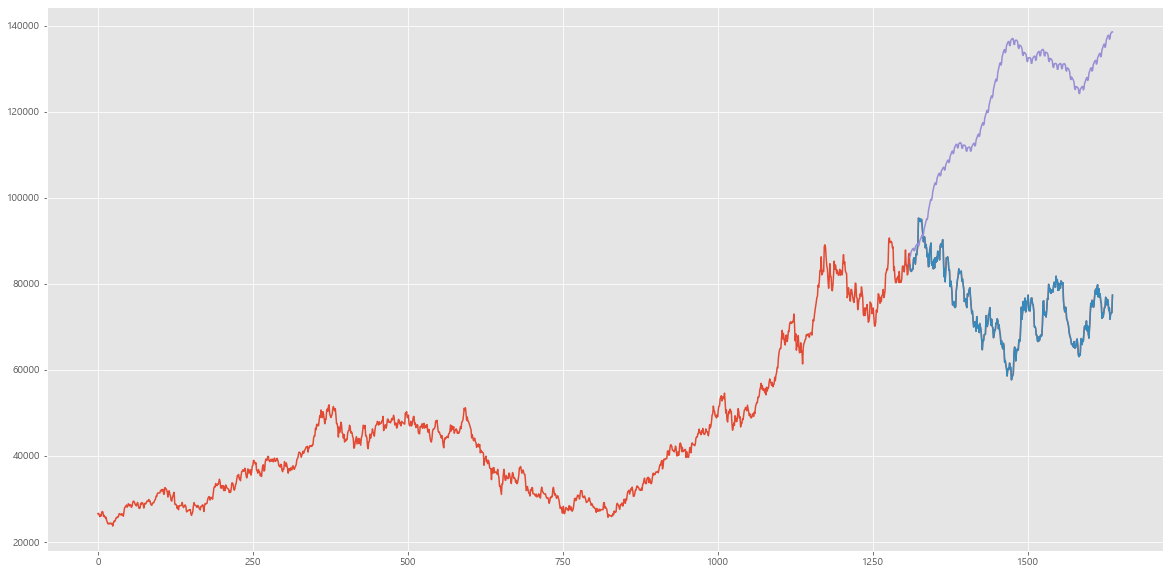

In [17]:
val6['PROPHET']=val_yhat
plt.figure(figsize=(20,10))
plt.plot(trval6['종가'])
plt.plot(val6[['종가','PROPHET']])

In [71]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(val_y, val_yhat)
rmse_pro = sqrt(mse)
rmse_pro

50839.67524784923

In [72]:
## mape값 
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [73]:
mape_pro = mean_absolute_percentage_error(val_y, val_yhat)
mape_pro

0.651719507358488

## ARIMA

In [74]:
data7=SK하이닉스_df[['날짜','종가']]
data7.reset_index(drop=True,inplace=True)

trval7=data7[(data7.날짜>='2013-01-01') & (data7.날짜<'2019-09-01')]
test7=data7[(data7.날짜>='2019-09-01') & (data7.날짜<='2019-12-31')]
train7, val7=train_test_split(trval,test_size=0.2,shuffle=False)

In [75]:
timeseries = train7

In [76]:
from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(timeseries.dropna())[1])

p-value: 0.9838832300196259


In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

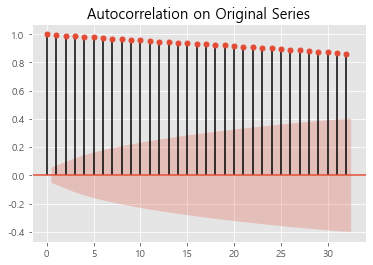

In [78]:
fig = plot_acf(timeseries, title="Autocorrelation on Original Series") 

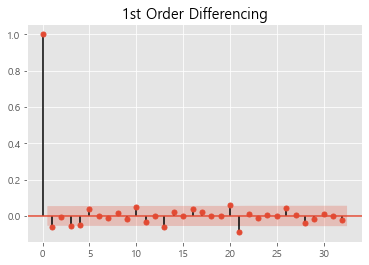

In [79]:
fig = plot_acf(timeseries.diff().dropna(),title="1st Order Differencing")

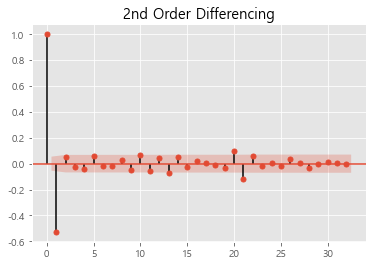

In [80]:
fig = plot_acf(timeseries.diff().diff().dropna(), title="2nd Order Differencing")

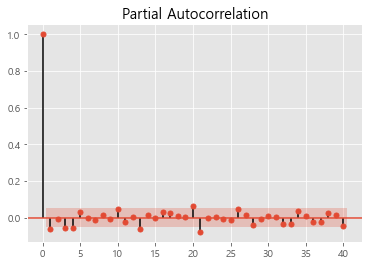

In [81]:
fig = plot_pacf(timeseries.diff().dropna(), lags=40)

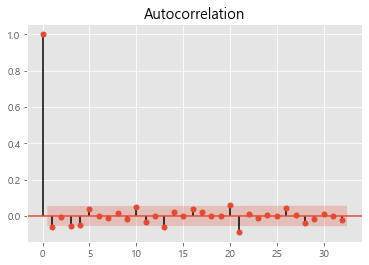

In [82]:
fig = plot_acf(timeseries.diff().dropna())

In [83]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(timeseries, order=(1, 1, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D.종가   No. Observations:                 1309
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10932.793
Method:                       css-mle   S.D. of innovations           1025.644
Date:                Sat, 05 Dec 2020   AIC                          21873.586
Time:                        17:16:55   BIC                          21894.294
Sample:                             1   HQIC                         21881.353
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.9970     23.913      1.923      0.054      -0.872      92.866
ar.L1.D.종가     0.6197      0.183      3.394      0.001       0.262       0.978
ma.L1.D.종가    -0.6794      0.170     -3.986      0.000      -1.013      -0.345
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6136           +0.0000j            1.6136            0.0000
MA.1            1.4720           +0.0000j            1.4720            0.0000
-----------------------------------------------------------------------------
"""

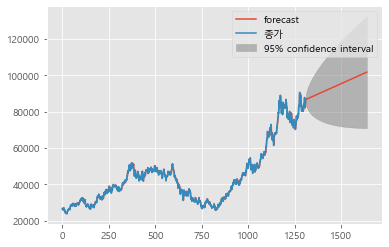

In [84]:
fig = results.plot_predict(1,1638)

In [85]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(timeseries, order=(1,1,1))
model_fit = model.fit(trend='nc',full_output=True, disp=0)  #constant안유효하다고 나옴
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.종가   No. Observations:                 1309
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10934.600
Method:                       css-mle   S.D. of innovations           1027.062
Date:                Sat, 05 Dec 2020   AIC                          21875.200
Time:                        17:16:56   BIC                          21890.731
Sample:                             1   HQIC                         21881.026
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.종가     0.5904      0.197      3.000      0.003       0.205       0.976
ma.L1.D.종가    -0.6476      0.185     -3.492      0.000      -1.011      -0.284
                                    Roots           

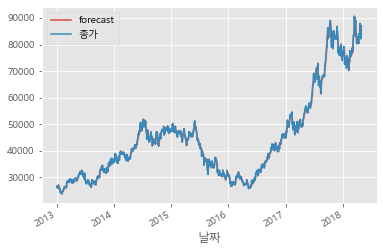

In [86]:
fig = model_fit.plot_predict()

In [87]:
fore= model_fit.forecast(steps=328)[0]

In [88]:
trval7 = trval7.set_index('날짜')

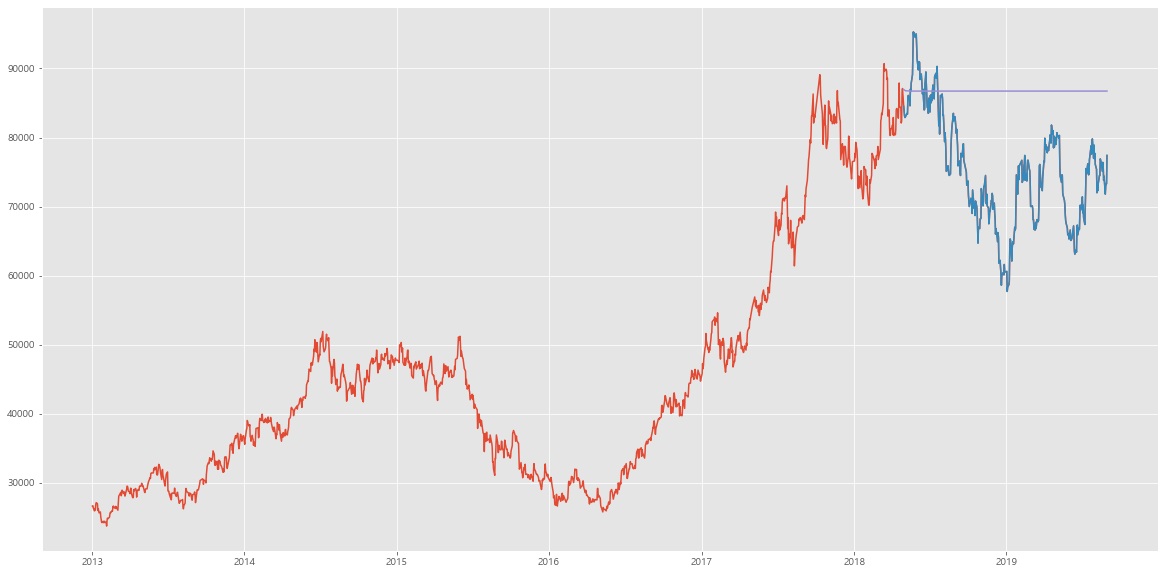

In [89]:
val7['arima']=fore
plt.figure(figsize=(20,10))
plt.plot(trval7)
plt.plot(val7[['종가','arima']])

In [90]:
rmse_arima =np.sqrt(np.mean(np.power((np.array(val7['종가'])-fore),2)))
rmse_arima

14148.23547805709

In [91]:
mape_arima = np.divide(np.sum(np.divide(np.absolute(np.array(val7['종가'])-fore),val7['종가']),0),val7['종가'].shape[0])
mape_arima

0.17514347229306504

## Random Forest

In [92]:
data8=SK하이닉스_df[['날짜','종가']]
data8.reset_index(drop=True,inplace=True)
trval8=data8[(data8.날짜>='2013-01-01') & (data8.날짜<'2019-09-01')]
test8=data8[(data8.날짜>='2019-09-01') & (data8.날짜<='2019-12-31')]
train8, val8=train_test_split(trval8,test_size=0.2,shuffle=False)

In [93]:
x=trval8.drop('종가',1)
y=trval8['종가']

tr_x, val_x=train_test_split(x,test_size=0.2,shuffle=False)
tr_y, val_y=train_test_split(y,test_size=0.2,shuffle=False)

In [94]:
from sklearn.ensemble import RandomForestRegressor

In [95]:
rf=RandomForestRegressor()
rf.fit(tr_x,tr_y)
rf_pred1=rf.predict(val_x)

In [96]:
params={'n_estimators':[10,20,30,100,200,300,350,400],'max_features':['auto','sqrt','log2'],'min_samples_split':[2,4,8],'bootstrap':[True,False],'max_depth':[1,2,5,7,9]}

In [97]:
best_rf=GridSearchCV(rf,param_grid=params,n_jobs=-1,cv=3)

best_rf.fit(tr_x,tr_y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 2, 5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 30, 100, 200, 300, 350, 400]})

In [98]:
best_rf.best_params_

{'bootstrap': True,
 'max_depth': 1,
 'max_features': 'auto',
 'min_samples_split': 4,
 'n_estimators': 30}

In [99]:
best_rf_predict=best_rf.predict(val_x)

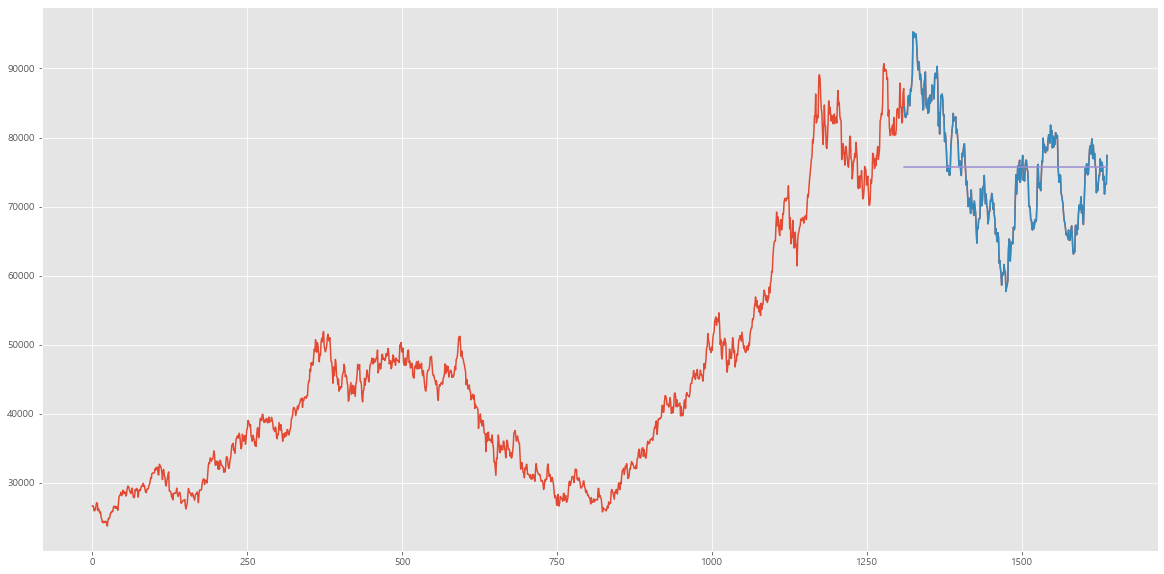

In [100]:
val8['pred2']=best_rf_predict
plt.figure(figsize=(20,10))
plt.plot(trval8['종가'])
plt.plot(val8[['종가','pred2']])

In [101]:
rmse_rf=np.sqrt(np.mean(np.power((val_y-best_rf_predict),2)))
rmse_rf

8054.031717573414

In [102]:
mape_rf = np.divide(np.sum(np.divide(np.absolute(np.array(val_y)-best_rf_predict),val_y),0),val_y.shape[0])
mape_rf

0.08888403605583117

## Support Vector Regression Linear Kernel

In [103]:
from sklearn.svm import SVR

In [104]:
svc=SVR(kernel='linear')

In [105]:
from sklearn.preprocessing import StandardScaler

In [106]:
sc=StandardScaler()

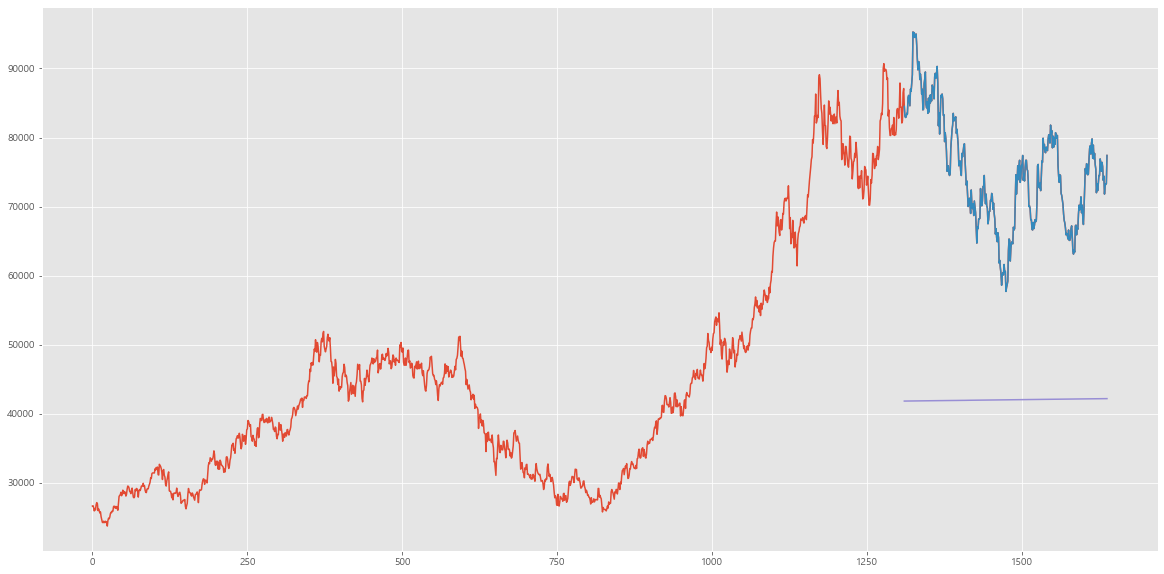

In [107]:
##버릴거임,,ㅎ
x_scaled=sc.fit_transform(x)
x_scaled=pd.DataFrame(x_scaled,index=x.index)
tr_x, val_x=train_test_split(x_scaled,test_size=0.2,shuffle=False)

svc.fit(tr_x,tr_y)
svc_pred=svc.predict(val_x)

val8['svc']=svc_pred
plt.figure(figsize=(20,10))
plt.plot(trval8['종가'])
plt.plot(val8[['종가','svc']])

In [108]:
new_y=trval8['종가'].values.reshape(-1,1)

x_scaled=sc.fit_transform(x)
x_scaled=pd.DataFrame(x_scaled,index=x.index)
y_scaled=sc.fit_transform(new_y)
y_scaled=pd.DataFrame(y_scaled,index=y.index)
tr_x2, val_x2=train_test_split(x_scaled,test_size=0.2,shuffle=False)
tr_y2, val_y2=train_test_split(y_scaled,test_size=0.2,shuffle=False)

In [109]:
svc.fit(tr_x2,tr_y2)

SVR(kernel='linear')

In [110]:
svc_pred_new=svc.predict(val_x2)

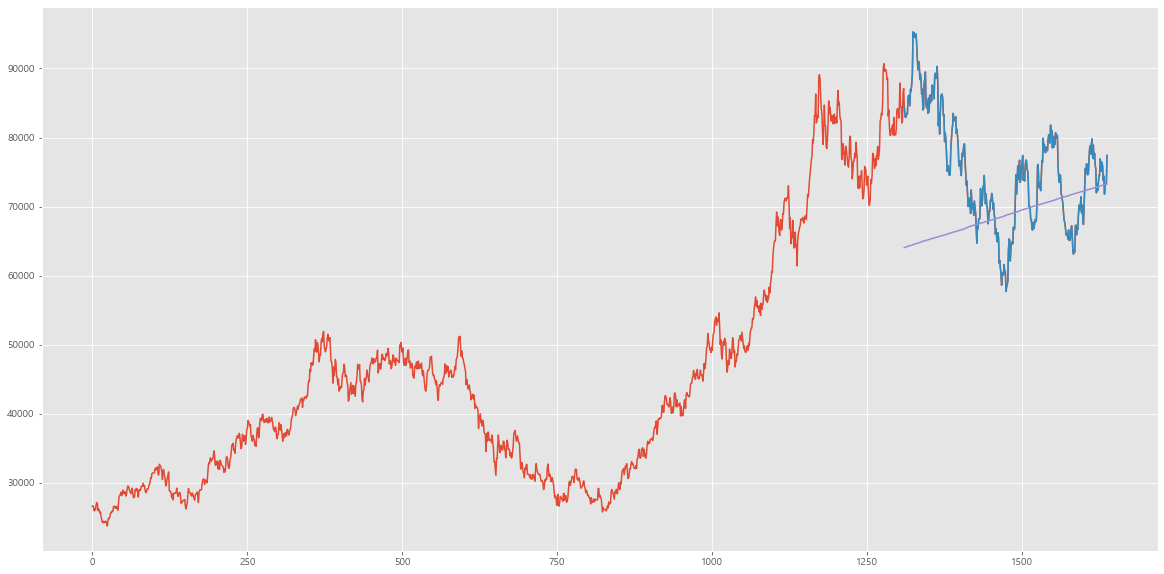

In [111]:
y_pred_svc=sc.inverse_transform(svc_pred_new)

val8['svc2']=y_pred_svc
plt.figure(figsize=(20,10))
plt.plot(trval8['종가'])
plt.plot(val8[['종가','svc2']])

In [112]:
rmse_svrlk=np.sqrt(np.mean(np.power((val_y-y_pred_svc),2)))
rmse_svrlk

11607.786678546921

In [113]:
mape_svrlk = np.divide(np.sum(np.divide(np.absolute(np.array(val_y)-y_pred_svc),val_y),0),val_y.shape[0])
mape_svrlk

0.10933162178837845

## Support Vector Regression( RBF Kernel )

In [114]:
svc1=SVR(kernel='rbf')
svc1.fit(tr_x2,tr_y2)

SVR()

In [115]:
svc_pred_rbf=svc1.predict(val_x)

y_pred_svc_rbf=sc.inverse_transform(svc_pred_rbf)

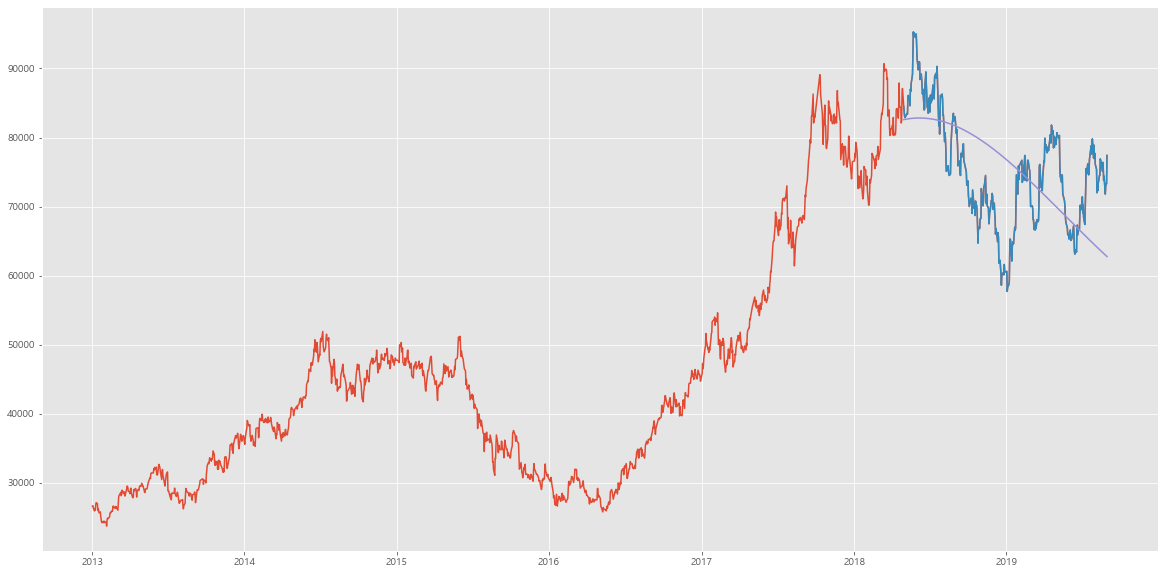

In [116]:
val7['svc3']=y_pred_svc_rbf
plt.figure(figsize=(20,10))
plt.plot(trval7['종가'])
plt.plot(val7[['종가','svc3']])

In [117]:
rmse_rbf =np.sqrt(np.mean(np.power((val_y-y_pred_svc_rbf),2)))
rmse_rbf

8079.089684062015

In [118]:
mape_rbf = np.divide(np.sum(np.divide(np.absolute(np.array(val_y)-y_pred_svc_rbf),val_y),0),val_y.shape[0])
mape_rbf

0.09162148941646048

---

## 오류지표

In [119]:
my_dict = {"rmse" : [rmse_ma, rmse_lm_1, rmse_poly, rmse_lm2, rmse_knn, rmse_hmm, rmse_pro, rmse_arima,rmse_rf, rmse_svrlk, rmse_rbf],
          "mape" : [mape_ma, mape_lm_1, mape_poly, mape_lm2, mape_knn, mape_hmm, mape_pro, mape_arima,mape_rf, mape_svrlk, mape_rbf]}

In [120]:
error = pd.DataFrame(my_dict)

In [121]:
error.index = ['Moving Average', 'Linear Model(1)', 'Polynomial Regression', 'Linear Model(2)', 'KNN', 'HMM', 'Prophet','Arima','Random Forest','SVR Linear Kernel','SVR RBF Kernel']

In [122]:
error

,rmse,mape
Moving Average,10046.741364,0.103832
Linear Model(1),11253.943648,0.106122
Polynomial Regression,25809.998395,0.317298
Linear Model(2),11292.062572,0.105975
KNN,32800.365563,0.316690
HMM,20067.838551,0.190755
Prophet,50839.675248,0.651720
Arima,14148.235478,0.175143
Random Forest,8054.031718,0.088884
SVR Linear Kernel,11607.786679,0.109332


**결론**

**Moving Average / Random Forest / SVR RBF Kernel**